<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Gen%20AI%20Foundational%20Models%20for%20NLP%20%26%20Language%20Understanding/Developing_a_Sequence_to_Sequence_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence-to-Sequence RNN Models: Translation Task**
---


## Setup


In [ ]:
!pip install torchtext==0.15.1
!pip install torch==2.0.0
!pip install spacy==3.7.2
!pip install torchdata==0.6.0
!pip install portalocker>=2.0.0
!pip install nltk==3.8.1
!pip install -U matplotlib

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Background
Seq2Seq models employ Recurrent Neural Networks (RNNs) to process variable-length input sequences and generate variable-length output sequences.


### Introduction to RNNs

RNNs have a recurrent connection that allows information to flow from one step to the next.
Recurrent Neural Networks (RNNs) operate on sequences and utilize previous states to influence the current state. Here's the general formulation of a simple RNN:


Given:

-$ \mathbf{x}_t $: input vector at time step $t$

-$ \mathbf{h}_{t-1} $: hidden state vector from the previous time step

-$ \mathbf{W}_x $ and $ \mathbf{W}_h $: weight matrices for the input and hidden state, respectively

-$ \mathbf{b} $: bias vector

-$ \sigma$: activation function (often a sigmoid or tanh)

-$ \mathbf{W}_o $: weight matrix for the output AND

-$ \mathbf{b}_o$: bias vector for the output

The update equations for the hidden state $ \mathbf{h}_t $ and the output $ \mathbf{y}_t $ are as follows:

$$
\begin{align*}
\mathbf{h}_t &= \sigma(\mathbf{W}_x \cdot \mathbf{x}_t + \mathbf{W}_h \cdot \mathbf{h}_{t-1} + \mathbf{b})
\end{align*}
$$

$$
\begin{align*}
\mathbf{y}_t &= \text{softmax}(\mathbf{W}_o \cdot \mathbf{h}_t + \mathbf{b}_o)
\end{align*}
$$


In [3]:
W_xh = torch.tensor(-10.0)
W_hh = torch.tensor(10.0)
b_h = torch.tensor(0.0)
x_t = 1
h_prev = torch.tensor(-1)

# Sequence X
X = [1,1,-1,-1,1,1]

# Hidden States
H = [-1,-1,0,1,0,-1]

In [4]:
# Initialize an empty list to store the predicted state values
H_hat = []
# Loop through each data point in the input sequence X
t=1
for x in X:
    # Assign the current data point to x_t
    print("t=",t)
    x_t = x
    # Print the value of the previous state (h at time t-1)
    print("h_t-1", h_prev.item())

    # Compute the current state (h at time t) using the RNN formula with tanh activation
    h_t = torch.tanh(x_t * W_xh + h_prev * W_hh + b_h)

    # Update h_prev to the current state value for the next iteration
    h_prev = h_t

    # Print the current input value (x at time t)
    print("x_t", x_t)

    # Print the computed state value (h at time t)
    print("h_t", h_t.item())
    print("\n")

    # Append the current state value to the H_hat list after converting it to integer
    H_hat.append(int(h_t.item()))
    t+=1

t= 1
h_t-1 -1
x_t 1
h_t -1.0


t= 2
h_t-1 -1.0
x_t 1
h_t -1.0


t= 3
h_t-1 -1.0
x_t -1
h_t 0.0


t= 4
h_t-1 0.0
x_t -1
h_t 1.0


t= 5
h_t-1 1.0
x_t 1
h_t 0.0


t= 6
h_t-1 0.0
x_t 1
h_t -1.0




In [5]:
# Predicted
H_hat

[-1, -1, 0, 1, 0, -1]

In [6]:
# Actual
H

[-1, -1, 0, 1, 0, -1]

### Sequence-to-sequence architecture

Seq2seq models have an Encoder-Decoder structure. The encoder encodes the input sequence into a fixed-dimensional representation, often called the context vector($h_t$). The decoder generates the output sequence based on the encoded context vector.


In practice, modifications and enhancements, such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), are often used to address issues like the vanishing gradient problem in basic RNNs.


An LSTM cell has three main components: an input gate, a forget gate, and an output gate.
- The **input gate** controls how much new information should be stored in the cell's memory. It looks at the current input and the previous hidden state and decides which parts of the new input to remember.
- The **forget gate** determines what information should be discarded or forgotten from the cell's memory. It considers the current input and the previous hidden state and decides which parts of the previous memory are no longer relevant.
- The **output gate** determines what information should be outputted from the cell. It looks at the current input and the previous hidden state and decides which parts of the cell's memory to include in the output.

The key idea behind LSTM cells is that they have a separate memory state that can selectively retain or forget information over time. This helps them handle long-range dependencies and remember important information from earlier steps in a sequence.


<video width="640" height="480"
src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Translation_RNN.mp4"
controls>
</video>


In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_len, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        #input_batch = [src len, batch size]
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)
        outputs, (hidden, cell) = self.lstm(embed)
        return hidden, cell

In [8]:
vocab_len = 8
emb_dim = 10
hid_dim = 8
n_layers = 1
dropout_prob = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

In [9]:
src_batch = torch.tensor([[0,3,4,2,1]])
# you need to transpose the input tensor as the encoder LSTM is in Sequence_first mode by default
src_batch = src_batch.t().to(device)
print("Shape of input(src) tensor:", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Hidden tensor from encoder:",hidden_t ,"\nCell tensor from encoder:", cell_t)

Shape of input(src) tensor: torch.Size([5, 1])
Hidden tensor from encoder: tensor([[[ 0.2033,  0.3063, -0.1951,  0.1791,  0.2234, -0.0955,  0.3404,
          -0.2240]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell tensor from encoder: tensor([[[ 0.5441,  0.5757, -0.2295,  0.2589,  0.5104, -0.3150,  0.6057,
          -0.3218]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


## Decoder implementation in PyTorch


<video width="640" height="480"
       src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/decoder_RNN.mp4"
       controls>
</video>


In [10]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        #input = [batch size]

        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)
        #prediction = [batch size, output dim]

        return prediction, hidden, cell

In [11]:
output_dim = 8
emb_dim = 10
hid_dim = 8
n_layers = 1
dropout = 0.5
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

In [12]:
input_t = torch.tensor([0]).to(device) #<bos>
input_t.shape
prediction, hidden, cell = decoder_t(input_t, hidden_t , cell_t)
print("Prediction:", prediction, '\nHidden:',hidden,'\nCell:', cell)

Prediction: tensor([[-2.2847, -2.1412, -1.9731, -2.0742, -1.8731, -2.1949, -2.4350, -1.8117]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>) 
Hidden: tensor([[[ 0.2073,  0.1850, -0.0209, -0.0270, -0.0282, -0.2703,  0.4291,
          -0.0447]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell: tensor([[[ 0.5011,  0.2540, -0.0399, -0.0652, -0.0738, -0.5332,  0.8585,
          -0.0963]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


# Encoder-decoder connection


In [13]:
# trg = [trg len, batch size]
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)

batch_size = trg.shape[1]
trg_len = trg.shape[0]
trg_vocab_size = decoder_t.output_dim

# Teacher_forcing_ratio is probability to use teacher forcing
teacher_forcing_ratio = 0.5

# Tensor to store decoder outputs
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

# Send to device
hidden_t = hidden_t.to(device)
cell_t = cell_t.to(device)

# First input to the decoder is the <bos> tokens
input = trg[0,:]

for t in range(1, trg_len):

    # Loop through the trg len and generate tokens
    # Decoder receives previous generated token, cell and hidden
    # Decoder outputs it prediction(probablity distribution for the next token) and updates hidden and cell
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)

    # Place predictions in a tensor holding predictions for each token
    outputs_t[t] = output_t

    # Decide if you are going to use teacher forcing or not
    teacher_force = random.random() < teacher_forcing_ratio

    # Get the highest predicted token from your predictions
    top1 = output_t.argmax(1)

    # If teacher forcing, use actual next token as next input
    # If not, use predicted token
    # Input = trg[t] if teacher_force else top1
    input = trg[t] if teacher_force else top1

print(outputs_t, outputs_t.shape) # The size of the output tensor is (trg_len, batch_size, trg_vocabsize)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]],

        [[-2.4048, -1.9809, -1.9654, -1.9993, -1.9341, -2.1950, -2.3809,
          -1.9114]],

        [[-2.1268, -2.0533, -2.0822, -1.9306, -1.9562, -2.3877, -2.3593,
          -1.8641]],

        [[-2.0705, -2.0719, -2.1787, -1.9324, -1.9767, -2.4738, -2.3054,
          -1.7871]],

        [[-2.2127, -2.1695, -1.9892, -2.0067, -1.8713, -2.2284, -2.4855,
          -1.8312]]], device='cuda:0', grad_fn=<CopySlices>) torch.Size([5, 1, 8])


In [14]:
# Note that you need to get the argmax from the second dimension as **outputs** is an array of **output** tensors
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [7],
        [7],
        [7],
        [7]], device='cuda:0')


In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab = trg_vocab

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)

        #first input to the decoder is the <bos> tokens
        input = trg[0,:]

        for t in range(1, trg_len):

            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if you are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from your predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            #input = trg[t] if teacher_force else top1
            input = trg[t] if teacher_force else top1

        return outputs

## Training model in PyTorch

In [16]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    train_iterator = tqdm(iterator, desc="Training", leave=False)

    for i, (src,trg) in enumerate(iterator):

        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].contiguous().view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

        epoch_loss += loss.item()


    return epoch_loss / len(list(iterator))

## Evaluating Model in PyTorch

In [17]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad():

        for i, (src,trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].contiguous().view(-1)


            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            # Update tqdm progress bar with the current loss
            valid_iterator.set_postfix(loss=loss.item())

            epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

## Data preprocessing


In [18]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'

--2024-12-23 19:07:30--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4890 (4.8K) [application/x-python]
Saving to: ‘Multi30K_de_en_dataloader.py’

Multi30K_de_en_data 100%[===================>]   4.78K  --.-KB/s    in 0s      

2024-12-23 19:07:30 (1.68 GB/s) - ‘Multi30K_de_en_dataloader.py’ saved [4890/4890]



In [19]:
%run Multi30K_de_en_dataloader.py

In [20]:
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)#,flip=True)

In [21]:
src, trg = next(iter(train_dataloader))
src,trg

(tensor([[    2,     2,     2,     2],
         [    3,  5510,  5510, 12642],
         [    1,     3,     3,     8],
         [    1,     1,     1,  1701],
         [    1,     1,     1,     3]], device='cuda:0'),
 tensor([[   2,    2,    2,    2],
         [   3, 6650,  216,    6],
         [   1, 4623,  110, 3398],
         [   1,  259, 3913,  202],
         [   1,  172, 1650,  109],
         [   1, 9953, 3823,   37],
         [   1,  115,   71,    3],
         [   1,  692, 2808,    1],
         [   1, 3428, 2187,    1],
         [   1,    5,    5,    1],
         [   1,    3,    3,    1]], device='cuda:0'))

In [22]:
data_itr = iter(train_dataloader)

# Moving forward in the dataset to reach sequences of longer length for illustration purpose. (Remember the dataset is sorted on sequence len for optimal padding)
for n in range(1000):
    german, english= next(data_itr)

for n in range(3):
    german, english=next(data_itr)
    german=german.T
    english=english.T
    print("________________")
    print("german")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("english")
    for e in english:
        print(index_to_eng(e))


________________
german
<bos> Personen mit schwarzen Hüten in der Innenstadt . <eos>
<bos> Eine Gruppe Menschen protestiert in einer Stadt . <eos>
<bos> Eine Gruppe teilt ihre politischen Ansichten mit . <eos>
<bos> Mehrere Personen sitzen an einem felsigen Strand . <eos>
________________
english
<bos> People in black hats gathered together downtown . <eos> <pad> <pad> <pad>
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
________________
german
<bos> Zwei sitzende Personen mit Hüten und Sonnenbrillen . <eos>
<bos> Ein kleiner Junge mit Hut beim Angeln . <eos>
<bos> Diese zwei Frauen haben Spaß im Giorgio's . <eos>
<bos> Zwei kleine Kinder schlafen auf dem Sofa . <eos>
________________
english
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two wome

# Training the model


### Training

In [23]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128 #256
DEC_EMB_DIM = 128 #256
HID_DIM = 256 #512
N_LAYERS = 1 #2
ENC_DROPOUT = 0.3 #0.5
DEC_DROPOUT = 0.3 #0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

In [24]:
def init_weights(m):
    # Each parameter is accessed as param and its corresponding name is accessed as name
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights) # Applies the init_weights function to the model instance

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,422,165 trainable parameters


In [26]:
optimizer = optim.Adam(model.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [27]:
# Helper Function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
torch.cuda.empty_cache()

N_EPOCHS = 3 #run the training for at least 5 epochs
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')


Epoch: 01 | Time: 3m 36s
	Train Loss: 4.389 | Train PPL:  80.558
	 Val. Loss: 5.278 |  Val. PPL: 195.994


Epoch: 02 | Time: 3m 36s
	Train Loss: 3.677 | Train PPL:  39.521
	 Val. Loss: 4.858 |  Val. PPL: 128.809


Epoch: 03 | Time: 3m 36s
	Train Loss: 3.273 | Train PPL:  26.397
	 Val. Loss: 4.520 |  Val. PPL:  91.866


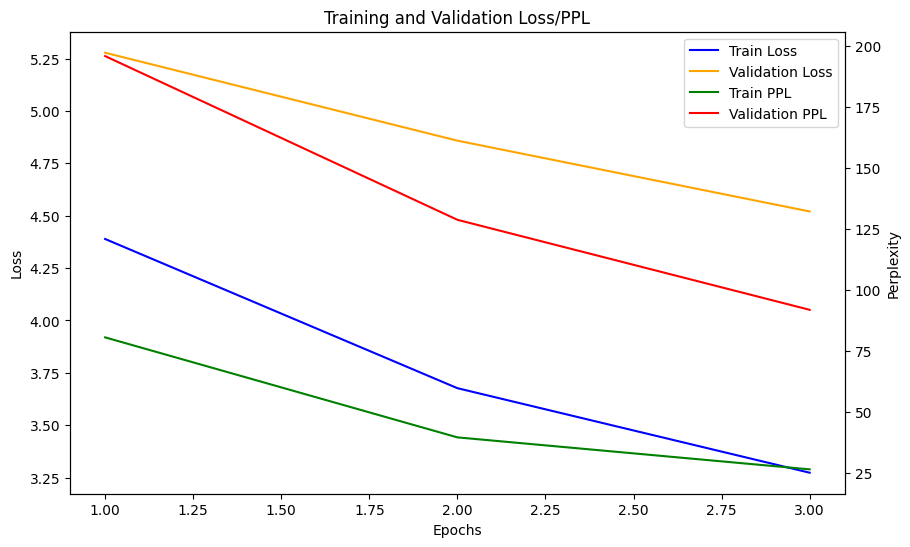

In [29]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plotting the training and validation loss
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

# Plotting the training and validation perplexity
ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

# Adjust the y-axis scaling for PPL plot
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Set the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')


# Show the plot
plt.show()


## Loading the saved model


In [30]:
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/RNN-TR-model.pt'
# model.load_state_dict(torch.load('RNN-TR-model.pt',map_location=torch.device('cpu')))

## Model inference


In [31]:
import torch.nn.functional as F

# Create a generator function that generates translations for input source sentences
def generate_translation(model, src_sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        # Pass the source tensor through the encoder
        hidden, cell = model.encoder(src_tensor)

        # Create a tensor to store the generated translation
        # get_stoi() maps tokens to indices
        trg_indexes = [trg_vocab.get_stoi()['<bos>']]  # Start with <bos> token

        # Convert the initial token to a PyTorch tensor
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

        # Move the tensor to the same device as the model
        trg_tensor = trg_tensor.to(model.device)


        # Generate the translation
        for _ in range(max_len):

            # Pass the target tensor and the previous hidden and cell states through the decoder
            output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell)

            # Get the predicted next token
            pred_token = output.argmax(1)[-1].item()

            # Append the predicted token to the translation
            trg_indexes.append(pred_token)


            # If the predicted token is the <eos> token, stop generating
            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            # Convert the predicted token to a PyTorch tensor
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

            # Move the tensor to the same device as the model
            trg_tensor = trg_tensor.to(model.device)

        # Convert the generated tokens to text
        # get_itos() maps indices to tokens
        trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

        # Remove the <sos> and <eos> from the translation
        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]

        # Return the translation list as a string

        translation = " ".join(trg_tokens)

        return translation

In [32]:
# model.load_state_dict(torch.load('RNN-TR-model.pt'))

# Actual translation: Asian man sweeping the walkway.
src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'

generated_translation = generate_translation(model, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
#generated_translation = " ".join(generated_translation_list).replace("<bos>", "").replace("<eos>", "")
print(generated_translation)

An Asian man is walking a a street street with a people


## BLEU score metric for evaluation
While peplexity serves as a general metric to evaluate the performance of language model in predicting the correct next token, BLEU score is helpful in evaluating the quality of the final generated translation.
Validating the results using BLEU score is helpful when there is more than a single valid translation for a sentence as you can include many translation versions in the reference list and compare the generated translation with different versions of translations.

The BLEU (Bilingual Evaluation Understudy) score is a metric commonly used to evaluate the quality of machine-generated translations by comparing them to one or more reference translations. It measures the similarity between the generated translation and the reference translations based on n-gram matching.

The BLEU score is calculated using the following formulas:

1. **Precision**:
   - Precision measures the proportion of n-grams in the generated translation that appear in the reference translations.
   - Precision is calculated for each n-gram order (1 to N) and then combined using a geometric mean.
   - The precision for a particular n-gram order is calculated as:
   
   $$\text{Precision}_n(t) = \frac{\text{CountClip}_n(t)}{\text{Count}_n(t)}$$
   
   where:
     - $\text{CountClip}_n(t)$ is the count of n-grams in the generated translation that appear in any reference translation, clipped by the maximum count of that n-gram in any single reference translation.
     - $\text{Count}_n(t)$ is the count of n-grams in the generated translation.

2. . **Brevity penalty**:
   - The brevity penalty accounts for the fact that shorter translations tend to have higher precision scores.
   - It encourages translations that are closer in length to the reference translations.
   - The brevity penalty is calculated as:
   
  $$\text{BP} = \begin{cases} 1 & \text{if } c > r \\\\\\\\\\\\ e^{(1 - \frac{r}{c})} & \text{if } c \leq r \end{cases}$$
   
   where:
     - $c$ is the total length of the generated translation.
     - $r$ is the total length of the reference translations.

3. **BLEU score**:
   - The BLEU score is the geometric mean of the precisions, weighted by the brevity penalty.
   - It is calculated as:
   
   $$\text{BLEU} = \text{BP} \cdot \exp(\sum_{n=1}^{N}w_n \log(\text{Precision}_n(t)))$$
   
   where:
     - $N$ is the maximum n-gram order.
     - $w_n$ is the weight assigned to the precision at n-gram order $n$, commonly set as $\frac{1}{N}$ for equal weights.


In [33]:
def calculate_bleu_score(generated_translation, reference_translations):
    # Convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # Calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [34]:
reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.21200626759025185


In [36]:
# Define the German text to be translated
german_text = "Menschen gehen auf der Straße"

# The function should be defined to accept the text, the model, source and target vocabularies, and the device as parameters.
english_translation = generate_translation(
    model,
    src_sentence=german_text,
    src_vocab=vocab_transform['de'],
    trg_vocab=vocab_transform['en'],
    max_len=50
)

# Display the original and translated text
print(f"Original German text: {german_text}")
print(f"Translated English text: {english_translation}")

Original German text: Menschen gehen auf der Straße
Translated English text: People walking walking down the street street in the street .


© Copyright IBM Corporation. All rights reserved.
